# 🦆 Volley Stats

*Author: Jasmol Singh Dhesi*

Python notebook to perform data analysis.

## 📩 Install Libraries

In [ ]:
import importlib.util
import subprocess
import sys

def ensure_packages(packages):
    """
    Ensure that the given package or list of packages are installed.
    If a package is not found, it will be installed via pip.

    Parameters:
    - packages (str or list of str): Package name or list of package names.
    """
    # Normalize to a list
    if isinstance(packages, str):
        packages = [packages]
    elif not isinstance(packages, (list, tuple)):
        raise ValueError("packages must be a string or a list/tuple of strings")

    for pkg in packages:
        if importlib.util.find_spec(pkg) is None:
            print(f"Installing missing package: {pkg}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        else:
            print(f"Package already installed: {pkg}")


In [ ]:
# install libraries
libraries = [
    "fuzzywuzzy",
    "levenshtein"]

ensure_packages(packages=libraries)

Package already installed: fuzzywuzzy
Installing missing package: levenshtein


In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## ⌛ Data Loading

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Modify this path to the appropriate location in your Drive
data = '/content/drive/MyDrive/Setting Ducks/Data/setting_ducks_stats.csv'

## 📖 Data Dictionary

| **field**        | **data_type** | **description**                                                                                      |
|-----------------|---------------|------------------------------------------------------------------------------------------------------|
| date             | datetime      | date of the match                                                                                    |
| season           | int           | IVL season (winter, spring, etc.)                                                                    |
| week_num         | int           | IVL season week number (e.g. 1, 2, etc.). Resets every season                                        |
| player_name      | str           | Name of the player                                                                                   |
| match_num        | int           | Match number                                                                                         |
| set_num          | int           | Number of the set played for the match                                                               |
| srv_errors       | int           | serving errors aka serve does legally not go in opponent court                                       |
| srv_good         | int           | serves that go into the opponents side of the court                                                  |
| srv_ace          | int           | service ace                                                                                          |
| srv_total        | int           | total serves attempted in the set                                                                    |
| rcv_error        | int           | serve-receive errors that result in a point being lost. this gets zero points towards receiving accuracy.                                               |
| rcv_bad          | int           | a serve-receive that doesn't lose a point but is far from the setter's position. overpasses fall into this category. this gets 1 point towards receiving accuracy.                      |
| rcv_good         | int           | a good serve-receive that lands close to the setter's optimal position. this gets two points towards receiving accuracy.                               |
| rcv_perfect      | int           | a perfect serve-receive. this gets three points towards receiving accuracy.                                                                             |
| rcv_total        | int           | total serve-receives by the player. multiply this by three to get total possible points when calculating receiving accuracy.                                                                   |
| atk_error        | int           | offensive attacks that lose a point                                                                  |
| atk_bad          | int           | offensive attacks that don't lose a point but aren't good (i.e. get blocked)                         |
| atk_good         | int           | offensive attacks that don't win a point but do penetrate the opponent's defense                     |
| atk_kill         | int           | successful offensive attacks that result in a point being won. i'm pretty generous with this so even if the opponents touch the ball, so long as they can't get control of it and it doesn't cross the net, i call it a kill                                        |
| atk_total        | int           | attacking attempts by a player. i count an attack as any attempt to get the ball over the net                                                                       |
| assists          | int           | assisted touches that allow another player to get a point (i.e. a set that results in a kill)        |
| defensive_error| int             | 	count of errors from trying to get a ball up/over (not an attack)|
| blk_error        | int           | blocking errors that result in the opponent's point (i.e. tools)                                     |
| blk_touch        | int           | block touches that don't result in a point either way                                                |
| blk_solo         | int           | successful blocks by a SINGLE person that result in a point                                          |
| blk_assist_2     | int           | successful blocks by TWO people that result in a point (all blockers are counted)                    |
| blk_assist_3     | int           | successful blocks by THREE people that result in a point (all blockers are counted)                  |
| blk_assist_total | int           | sum of all blk_assist                                                                               |
| blk_total        | float           | total number of blocks = blk_solo + blk_assist_2 / 2 + blk_assist_3 / 3. Round to two decimal places to account for multples of three   |
| dig_miss         | int           | downballs in a player's region that were not touched                                                 |
| dig_touch        | int           | downballs the player makes contact with but not necessarily up                                       |
| dig_up           | int           | downballs dug up by a player that keep the ball alive                                                |
| dig_total        | int           | total number of possible digs                                                                        |
| win              | boolean       | boolean for whether we won the set or not (1 or 0)                                                   |
|fouls    | int | number of fouls |
|position | str | position of the player |


## 🥅 Passing Zones

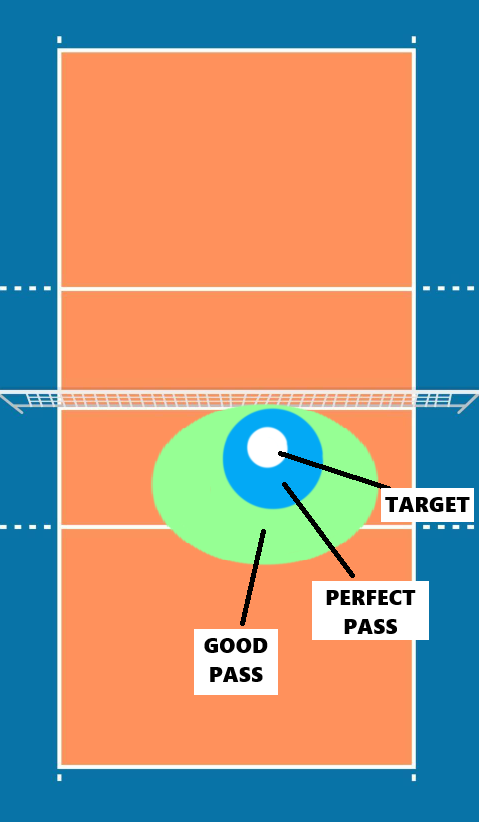

Anywhere outside of the good pass is a bad pass. If a pass is missed or shanked so bad we can't get it over the net, that is considered an error.

In calculating passing accuracy, I use a three point system (see below).

Pass Scoring:
- Perfect Pass - 3
- Good Pass - 2
- Bad Pass - 1
- Passing Error - 0

After calculating the total score for passing, I divide by total possible points. Three significant digits are used.

$$
\text{Passing Accuracy} = \frac{\sum_{i=1}^{n} \text{score}_i}{\text{Total Passes} * 3}
$$

Also, yes I drew this image 😆

## 🔭 EDA

Show all columns

In [ ]:
# Configure pandas to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

Import Data

In [ ]:
import pandas as pd

def load_and_summarize_csv(file_path: str, review: bool = False):
    """
    Loads a CSV file into a pandas DataFrame,
    standardizes column names to lowercase,
    and provides a summary including shape, data types,
    missing values, and basic statistics.

    Parameters:
    -----------
    file_path : str
        The path to the CSV file.
    review : bool, optional
        If True, prints the DataFrame summary. Default is False.

    Returns:
    --------
    pandas.DataFrame
        The cleaned DataFrame with lowercase column names.
    """

    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Convert column names to lowercase
    df.columns = df.columns.str.lower()

    # Print DataFrame summary
    if review:
        print(f"📊 Shape of the DataFrame (rows, columns): {df.shape}\n")
        print(f"🔍 Data types of each column:\n{df.dtypes}\n")
        # print(f"⚠️ Number of missing values in each column:\n{df.isna().sum()}\n")
        print(f"📈 Descriptive statistics of the DataFrame:\n{df.describe()}\n")

    return df  # Return the cleaned DataFrame


In [ ]:
# Loading the data:
df_raw = load_and_summarize_csv(data, review = True)
df_raw.sort_values(by='date', ascending=True).head()

📊 Shape of the DataFrame (rows, columns): (126, 31)

🔍 Data types of each column:
date                object
format              object
season              object
week_num           float64
player_name         object
match_num            int64
set_num              int64
srv_error           object
srv_good           float64
srv_ace            float64
rcv_error           object
rcv_bad             object
rcv_good           float64
rcv_perfect         object
atk_error          float64
atk_bad             object
atk_good           float64
atk_kill            object
assists            float64
defensive_error    float64
blk_error          float64
blk_touch          float64
blk_solo           float64
blk_assist_2       float64
blk_assist_3       float64
dig_miss            object
dig_touch           object
dig_up             float64
fouls              float64
win                  int64
position            object
dtype: object

📈 Descriptive statistics of the DataFrame:
         week_num   mat

,date,format,season,week_num,player_name,match_num,set_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,position
0,2/25/2025,IVL,Winter,6.0,Allyn,1,1,NaN,4.0,NaN,4,NaN,NaN,2,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,outside
23,2/25/2025,IVL,Winter,6.0,Michael,2,2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,setter
22,2/25/2025,IVL,Winter,6.0,Maddy,2,2,NaN,1.0,1.0,4,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,outside
21,2/25/2025,IVL,Winter,6.0,Luis,2,2,NaN,3.0,2.0,NaN,1,NaN,NaN,1.0,NaN,NaN,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,middle
20,2/25/2025,IVL,Winter,6.0,Jasmol,2,2,1,7.0,NaN,2,2,NaN,2,NaN,NaN,2.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,middle


### ✂ Split Data By Player

In [ ]:
import os

# Define the target folder path in Google Drive
folder_path = "/content/drive/MyDrive/Setting Ducks/Data/player_data"

# Ensure 'Data' folder exists
os.makedirs(folder_path, exist_ok=True)

# Iterate over unique player names and save each subset as a separate CSV
for player in df_raw['player_name'].unique():
    file_path = os.path.join(folder_path, f"{player}.csv")  # Construct file path
    df_raw[df_raw['player_name'] == player].to_csv(
        file_path, index=False, mode='w'  # 'w' mode ensures overwriting
    )
    print(f"Data for {player} saved to {file_path}")

print("\nAll data subsets saved to 'Data' folder.")


Data for Allyn saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Allyn.csv
Data for Andres saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Andres.csv
Data for Jasmol saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Jasmol.csv
Data for Luis saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Luis.csv
Data for Maddy saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Maddy.csv
Data for Michael saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Michael.csv
Data for Carleen saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Carleen.csv
Data for Cesar saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Cesar.csv
Data for Cherry saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Cherry.csv
Data for Brandon saved to /content/drive/MyDrive/Setting Ducks/Data/player_data/Brandon.csv

All data subsets saved to 'Data' folder.


### 🎮 Player Selection

Code to filter all data by player should I need to run analyses for individuals.
___

Get the player names to pick from.

In [ ]:
# Get a sorted list of unique lowercase player names
player_list = sorted(df_raw['player_name'].str.lower().unique())

# Display the list of player names
print(player_list)


['allyn', 'andres', 'brandon', 'carleen', 'cesar', 'cherry', 'jasmol', 'luis', 'maddy', 'michael']


Make a function to filter data with a player name.

In [ ]:
from fuzzywuzzy import process

def get_player_data(df, player_name):
    """
    Retrieve data for a specific player or all players if input is empty.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing player statistics.
    player_name : str
        The name of the player to filter data for.
        - If empty (""), the full dataset is returned.
        - If an invalid name is given, the most similar player name is suggested.

    Returns:
    --------
    tuple
        - pandas.DataFrame: Data for the specified player or all players.
        - str: The actual name used for filtering (empty if all players).
    """

    # List of unique lowercase player names
    player_list = sorted(df['player_name'].str.lower().unique())

    # If input is empty, return all players
    if not player_name.strip():
        print("Retrieved data for all players!")
        return df, ""

    # Lowercase input for matching
    player_name_lower = player_name.lower()

    # If the name isn't found, suggest the closest match
    if player_name_lower not in player_list:
        closest_match, score = process.extractOne(player_name_lower, player_list)
        if score >= 80:  # adjust threshold as needed
            print(f"Invalid player name. \nUsing closest match: '{closest_match}'. (Score: {score})")
            matched_df = df[df['player_name'].str.lower() == closest_match]
            return matched_df, closest_match
        else:
            raise ValueError(
                f"Error: '{player_name}' not found. No close match found."
            )

    # Exact match case
    print(f"Retrieved data for {player_name_lower.title()}!")
    matched_df = df[df['player_name'].str.lower() == player_name_lower]
    return matched_df, player_name_lower

In [ ]:
# Example usage:
player_name = input("Enter a player name (or press enter for all players): ")
try:
    df, player_name = get_player_data(df_raw, player_name)
except ValueError as e:
    print(e)

if len(player_name) == 0:
    player_name =  "Team"
else:
    player_name = player_name.title()

df.head()  # Show first few rows

Enter a player name (or press enter for all players): Cesar
Retrieved data for Cesar!


,date,format,season,week_num,player_name,match_num,set_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,position
37,4/8/2025,IVL,Spring,2.0,Cesar,1,1,1,4.0,NaN,1,NaN,NaN,2,1.0,2,4.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1,outside
43,4/8/2025,IVL,Spring,2.0,Cesar,1,2,NaN,1.0,1.0,1,1,NaN,1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1,outside
49,4/15/2025,IVL,Spring,3.0,Cesar,1,1,NaN,4.0,3.0,NaN,2,NaN,5,4.0,3,7.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,outside
55,4/15/2025,IVL,Spring,3.0,Cesar,1,2,1,1.0,NaN,NaN,3,NaN,6,4.0,NaN,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,outside
61,4/15/2025,IVL,Spring,3.0,Cesar,2,2,NaN,3.0,1.0,NaN,2,NaN,3,4.0,1,8.0,3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0,outside


### 🧼 Data Cleaning

Here we make all the dataframes we need for our analysis:
- Base df
- Grouped df which omits the set number and match to sum all values by player and date

We'll also add relevent columns to calculate metrics such as percentage error.

#### Convert Data Types

In [ ]:
# Make a copy rather than copying from a slice
df = df.copy()

# convert to appropriate data types
df['date'] = pd.to_datetime(df['date'])
df['match_num'] = df['match_num'].astype(str)
df['week_num'] = df['week_num'].astype(str)
df['set_num'] = df['set_num'].astype(str)
df['player_name'] = df['player_name'].astype(str)
df['position'] = df['position'].astype(str)
df['season'] = df['season'].astype(str)
df['win'] = df['win'].astype(bool)
df['year'] = pd.to_datetime(df['date']).dt.year

# List of columns to convert to float and replace NaN with 0
cols_to_float = [
    'srv_error', 'srv_good', 'srv_ace',
    'rcv_error', 'rcv_bad', 'rcv_good', 'rcv_perfect',
    'atk_error','atk_bad', 'atk_good', 'atk_kill', 'assists',
    'blk_error', 'blk_solo', 'blk_assist_2', 'blk_assist_3',
    'dig_miss', 'dig_touch', 'dig_up', 'defensive_error', 'fouls'
]

# Coerce non-numeric to NaN, convert to float, then fill NaN with 0
df[cols_to_float] = df[cols_to_float].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
                    .astype(float)
                    .fillna(0)
)
df.dtypes

,0
date,datetime64[ns]
format,object
season,object
week_num,object
player_name,object
match_num,object
set_num,object
srv_error,float64
srv_good,float64
srv_ace,float64


In [ ]:
# Lowercase the 'season', 'player_name', and 'format' columns
df['season'] = df['season'].str.lower()
df['player_name'] = df['player_name'].str.lower()
df['format'] = df['format'].str.lower()

# make a 'lose' column
df['lose'] = ~df['win']

# Replace all NaNs with 0 without inplace on a view
df = df.fillna(0)

df.tail()

,date,format,season,week_num,player_name,match_num,set_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,position,year,lose
93,2025-04-29,ivl,spring,5.0,cesar,2,2,0.0,4.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,6.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,outside,2025,True
103,2025-05-06,ivl,spring,6.0,cesar,1,1,1.0,2.0,0.0,0.0,2.0,4.0,1.0,1.0,0.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,True,outside,2025,False
109,2025-05-06,ivl,spring,6.0,cesar,1,2,0.0,6.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,outside,2025,True
115,2025-05-06,ivl,spring,6.0,cesar,2,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,outside,2025,False
121,2025-05-06,ivl,spring,6.0,cesar,2,2,1.0,3.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,True,outside,2025,False


#### Derive Features

Calculate totals for each play

In [ ]:
# total attacks
df['atk_total'] = (
    df['atk_error'] + df['atk_bad'] + df['atk_good'] + df['atk_kill']
)

# total service attempts
df['srv_total'] = (
    df['srv_error'] + df['srv_good'] + df['srv_ace']
)

# total reception attempts
df['rcv_total'] = (
    df['rcv_error'] + df['rcv_bad'] + df['rcv_good'] + df['rcv_perfect']
)

# total blocks that resulted in points
df['blk_total'] = (
    df['blk_solo'] + df['blk_assist_2'] / 2 + df['blk_assist_3'] / 3
)

# total dig attempts
df['dig_total'] = (
    df['dig_miss'] + df['dig_touch'] + df['dig_up']
)

# view changes
df.tail()

,date,format,season,week_num,player_name,match_num,set_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,position,year,lose,atk_total,srv_total,rcv_total,blk_total,dig_total
93,2025-04-29,ivl,spring,5.0,cesar,2,2,0.0,4.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,6.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,outside,2025,True,10.0,4.0,6.0,0.0,1.0
103,2025-05-06,ivl,spring,6.0,cesar,1,1,1.0,2.0,0.0,0.0,2.0,4.0,1.0,1.0,0.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,True,outside,2025,False,9.0,3.0,7.0,0.0,4.0
109,2025-05-06,ivl,spring,6.0,cesar,1,2,0.0,6.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,outside,2025,True,10.0,7.0,4.0,0.0,0.0
115,2025-05-06,ivl,spring,6.0,cesar,2,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,outside,2025,False,13.0,3.0,1.0,0.0,1.0
121,2025-05-06,ivl,spring,6.0,cesar,2,2,1.0,3.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,True,outside,2025,False,7.0,4.0,4.0,0.0,3.0


### 🛑 Filter Data

In [ ]:
# Filter data by year, format, or IVL season
df = df[df['format'] == 'ivl']
# df = df[df['year'] == 2025]
df = df[df['season'] != 'winter']

df = df.copy()
df.tail()

,date,format,season,week_num,player_name,match_num,set_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,position,year,lose,atk_total,srv_total,rcv_total,blk_total,dig_total
93,2025-04-29,ivl,spring,5.0,cesar,2,2,0.0,4.0,0.0,0.0,4.0,2.0,0.0,2.0,0.0,6.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,outside,2025,True,10.0,4.0,6.0,0.0,1.0
103,2025-05-06,ivl,spring,6.0,cesar,1,1,1.0,2.0,0.0,0.0,2.0,4.0,1.0,1.0,0.0,5.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,True,outside,2025,False,9.0,3.0,7.0,0.0,4.0
109,2025-05-06,ivl,spring,6.0,cesar,1,2,0.0,6.0,1.0,1.0,2.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,outside,2025,True,10.0,7.0,4.0,0.0,0.0
115,2025-05-06,ivl,spring,6.0,cesar,2,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,outside,2025,False,13.0,3.0,1.0,0.0,1.0
121,2025-05-06,ivl,spring,6.0,cesar,2,2,1.0,3.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,True,outside,2025,False,7.0,4.0,4.0,0.0,3.0


## 🛠 Feature Engineering

### ➗ Calculating Metrics

#### 🎯 Accuracy Metrics

- Hitting percentage = (Kill - Error) / Total attacks
- Serving Accuracy = (Total - Error) / Total
- Receiving Accuracy = (Perfect * 3 + Good * 2 + Bad * 1) / (Total * 3)

In [ ]:
import pandas as pd

def add_accuracy_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute and add accuracy and error metrics to the DataFrame.

    Adds the following columns:
    - srv_accuracy: serve success rate (srv_total - srv_error) / srv_total
    - rcv_accuracy: weighted receive accuracy based on rcv_perfect, rcv_good, rcv_bad
    - atk_accuracy: hitting accuracy (atk_kill - atk_error) / atk_total
    - total_errors: sum of srv_error, rcv_error, and atk_error

    Parameters:
    df (pd.DataFrame): Input DataFrame containing columns:
        srv_total, srv_error,
        rcv_total, rcv_perfect, rcv_good, rcv_bad,
        atk_total, atk_kill, atk_error.

    Returns:
    pd.DataFrame: The same DataFrame with new metric columns added.
    """
    df = df.copy()

    # Serve success rate
    df['srv_accuracy'] = round(
        (df['srv_total'] - df['srv_error']) / df['srv_total'],
        3
    )

    # Serve-receive accuracy (weighted)
    df['rcv_accuracy'] = round(
        (df['rcv_perfect'] * 3 +
         df['rcv_good']    * 2 +
         df['rcv_bad']      * 1) /
        (df['rcv_total']   * 3),
        3
    )

    # Hitting accuracy
    df['atk_accuracy'] = round(
        (df['atk_kill'] - df['atk_error']) / df['atk_total'],
        3
    )

    # Total errors
    df['total_errors'] = (
        df['srv_error'] +
        df['rcv_error'] +
        df['atk_error'] +
        df['blk_error'] +
        df['defensive_error']
        # + df['dig_miss']    # opponent earns these usually. not an error
    )

    return df

# Example usage:
# team_overall = add_accuracy_metrics(team_overall)


#### 📏 Average Metrics by Set

In [ ]:
import pandas as pd

def add_average_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute per-game average stats for serving, receiving, offense, and errors.
    Adds columns:
      avg_srv_ace, avg_total_serves,
      avg_rcv_good, avg_rcv_bad, avg_rcv_perfect, avg_total_rcv,
      avg_atk_good, avg_atk_bad, avg_total_atk, avg_kills,
      avg_atk_errors, avg_rcv_errors, avg_srv_errors, avg_tot_errors
    """
    df = df.copy()

    # Serve metrics
    df['avg_srv_ace']     = round(df['srv_ace']     / df['games_count'], 1)
    df['avg_total_serves'] = round(df['srv_total']   / df['games_count'], 1)

    # Receive metrics
    df['avg_rcv_good']     = round(df['rcv_good']    / df['games_count'], 1)
    df['avg_rcv_bad']      = round(df['rcv_bad']     / df['games_count'], 1)
    df['avg_rcv_perfect']  = round(df['rcv_perfect'] / df['games_count'], 1)
    df['avg_total_rcv']    = round(df['rcv_total']   / df['games_count'], 1)

    # Offense metrics
    df['avg_atk_good']     = round(df['atk_good']    / df['games_count'], 1)
    df['avg_atk_bad']      = round(df['atk_bad']     / df['games_count'], 1)
    df['avg_total_atk']    = round(df['atk_total']   / df['games_count'], 1)
    df['avg_kills']        = round(df['atk_kill']    / df['games_count'], 1)

    # Error metrics
    df['avg_atk_errors']   = round(df['atk_error']   / df['games_count'], 2)
    df['avg_rcv_errors']   = round(df['rcv_error']   / df['games_count'], 2)
    df['avg_srv_errors']   = round(df['srv_error']   / df['games_count'], 2)
    df['avg_tot_errors']   = round(df['total_errors']/ df['games_count'], 2)
    df['avg_blk_errors']   = round(df['blk_error']   / df['games_count'], 2)
    df['avg_def_errors']   = round(df['defensive_error']/ df['games_count'], 2)

    return df

# Example usage:
# team_overall = add_average_metrics(team_overall)


### ⏸ Intermediate DataFreames

#### 📅 Grouped By Date

Make a df that is grouped by the date by dropping the match and set number and adding all metrics. This allows us to take averages and other calculations by date.

In [ ]:
# Group data to sum all counts for a given date
df_grouped = (
    df.drop(['set_num', 'match_num'], axis=1)
    .groupby([
        'date',
        'format',
        'season',
        'week_num',
        'player_name',
        'year',
        'position'])
    .sum()
    .reset_index()
)

# add games_count col (wins + lose)
df_grouped['games_count'] = df_grouped['win'] + df_grouped['lose']

df_grouped.tail (10)

,date,format,season,week_num,player_name,year,position,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,games_count
0,2025-04-08,ivl,spring,2.0,cesar,2025,outside,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0,2
1,2025-04-15,ivl,spring,3.0,cesar,2025,outside,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0,3
2,2025-04-22,ivl,spring,4.0,cesar,2025,outside,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0,4
3,2025-04-29,ivl,spring,5.0,cesar,2025,outside,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0,2
4,2025-05-06,ivl,spring,6.0,cesar,2025,outside,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0,4


#### 🏃 Grouped By Player

Make a df for overall statistics for a player (no date).

In [ ]:
# make a new df by dropping 'date', 'week_num', and 'position' and regrouping
df_overall = (
    df_grouped.drop([
        'date',
        'week_num',
        'position',
        'year',
        'format',
        'season'], axis=1)
    .groupby([
    'player_name'])
    .sum()
    .reset_index()
)

# view dataframe
df_overall.tail(10)

,player_name,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,games_count
0,cesar,7.0,45.0,7.0,7.0,27.0,11.0,31.0,26.0,8.0,71.0,38.0,1.0,3.0,3.0,1.0,2.0,0.0,0.0,2.0,4.0,11.0,1.0,9,6,143.0,59.0,76.0,2.0,17.0,15


In [ ]:
# add accuracy metrics
df_overall = add_accuracy_metrics(df_overall)

# view data
df_overall.head(10)

,player_name,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,games_count,srv_accuracy,rcv_accuracy,atk_accuracy,total_errors
0,cesar,7.0,45.0,7.0,7.0,27.0,11.0,31.0,26.0,8.0,71.0,38.0,1.0,3.0,3.0,1.0,2.0,0.0,0.0,2.0,4.0,11.0,1.0,9,6,143.0,59.0,76.0,2.0,17.0,15,0.881,0.623,0.084,46.0


#### 💏Team DataFrames

Get Overall DF grouped by the date for time-series analysis

In [ ]:
# Regroup by player_name to account for different positions played
team_overall = (
    df_grouped.drop([
        'position',
        'format',
        'season'], axis=1)
    .groupby([
    'date',
    'year',
    'player_name',
    'week_num']).sum().reset_index()
)

team_overall.tail()

,date,year,player_name,week_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,games_count
0,2025-04-08,2025,cesar,2.0,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0,2
1,2025-04-15,2025,cesar,3.0,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0,3
2,2025-04-22,2025,cesar,4.0,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0,4
3,2025-04-29,2025,cesar,5.0,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0,2
4,2025-05-06,2025,cesar,6.0,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0,4


In [ ]:
# Regroup (w/o player_name) by games_count to account for all players on a date
team_overall = (
    team_overall.drop([
        'player_name',
        ], axis=1)
    .groupby([
    'date',
    'year',
    'games_count',
    'week_num']).sum().reset_index()
)

team_overall.tail()

,date,year,games_count,week_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total
0,2025-04-08,2025,2,2.0,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0
1,2025-04-15,2025,3,3.0,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0
2,2025-04-22,2025,4,4.0,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0
3,2025-04-29,2025,2,5.0,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0
4,2025-05-06,2025,4,6.0,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0


In [ ]:
# add all metrics
team_overall = add_accuracy_metrics(team_overall)
team_overall = add_average_metrics(team_overall)

# view data
team_overall.tail()

,date,year,games_count,week_num,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,srv_accuracy,rcv_accuracy,atk_accuracy,total_errors,avg_srv_ace,avg_total_serves,avg_rcv_good,avg_rcv_bad,avg_rcv_perfect,avg_total_rcv,avg_atk_good,avg_atk_bad,avg_total_atk,avg_kills,avg_atk_errors,avg_rcv_errors,avg_srv_errors,avg_tot_errors,avg_blk_errors,avg_def_errors
0,2025-04-08,2025,2,2.0,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0,0.857,0.556,0.100,4.0,0.5,3.5,0.0,0.5,1.5,3.0,2.5,1.0,5.0,1.0,0.50,1.00,0.50,2.00,0.0,0.00
1,2025-04-15,2025,3,3.0,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0,0.923,0.778,-0.098,13.0,1.3,4.3,0.0,2.3,4.7,7.0,5.7,1.3,13.7,2.7,4.00,0.00,0.33,4.33,0.0,0.00
2,2025-04-22,2025,4,4.0,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0,0.818,0.606,0.179,11.0,0.0,2.8,0.0,1.8,2.8,5.5,3.0,0.2,7.0,2.5,1.25,1.00,0.50,2.75,0.0,0.00
3,2025-04-29,2025,2,5.0,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0,1.000,0.485,0.120,5.0,0.0,5.5,1.5,3.5,0.5,5.5,7.0,0.0,12.5,3.5,2.00,0.00,0.00,2.50,0.5,0.00
4,2025-05-06,2025,4,6.0,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0,0.824,0.562,0.179,13.0,0.5,4.2,2.0,1.2,0.5,4.0,5.8,0.2,9.8,2.8,1.00,0.25,0.75,3.25,0.5,0.75


#### 🏃📅 Player and Date

In [ ]:
df_grouped.tail()

,date,format,season,week_num,player_name,year,position,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,games_count
0,2025-04-08,ivl,spring,2.0,cesar,2025,outside,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0,2
1,2025-04-15,ivl,spring,3.0,cesar,2025,outside,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0,3
2,2025-04-22,ivl,spring,4.0,cesar,2025,outside,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0,4
3,2025-04-29,ivl,spring,5.0,cesar,2025,outside,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0,2
4,2025-05-06,ivl,spring,6.0,cesar,2025,outside,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0,4


In [ ]:
# regroup and take sum
df_player_date = df_grouped.groupby([
    'date',
    'year',
    'season',
    'week_num',
    'position',
    'games_count',
    'player_name']).sum().reset_index()

# sort by date asc
df_player_date.sort_values('date', inplace=True)

# make df without the 'position column and regroup
df_player_date_no_pos = (
    df_player_date.drop(columns=['position'])
    .groupby([
        'date',
        'year',
        'season',
        'week_num',
        'player_name',
        'format'
        ])
    .sum()
    .reset_index()
)

# view dataframe
df_player_date.tail()

,date,year,season,week_num,position,games_count,player_name,format,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total
0,2025-04-08,2025,spring,2.0,outside,2,cesar,ivl,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0
1,2025-04-15,2025,spring,3.0,outside,3,cesar,ivl,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0
2,2025-04-22,2025,spring,4.0,outside,4,cesar,ivl,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0
3,2025-04-29,2025,spring,5.0,outside,2,cesar,ivl,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0
4,2025-05-06,2025,spring,6.0,outside,4,cesar,ivl,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0


In [ ]:
# get metrics
df_player_date = add_accuracy_metrics(df_player_date)
df_player_date = add_average_metrics(df_player_date)

df_player_date_no_pos = add_accuracy_metrics(df_player_date_no_pos)
df_player_date_no_pos = add_average_metrics(df_player_date_no_pos)

# view data
df_player_date.tail()

,date,year,season,week_num,position,games_count,player_name,format,srv_error,srv_good,srv_ace,rcv_error,rcv_bad,rcv_good,rcv_perfect,atk_error,atk_bad,atk_good,atk_kill,assists,defensive_error,blk_error,blk_touch,blk_solo,blk_assist_2,blk_assist_3,dig_miss,dig_touch,dig_up,fouls,win,lose,atk_total,srv_total,rcv_total,blk_total,dig_total,srv_accuracy,rcv_accuracy,atk_accuracy,total_errors,avg_srv_ace,avg_total_serves,avg_rcv_good,avg_rcv_bad,avg_rcv_perfect,avg_total_rcv,avg_atk_good,avg_atk_bad,avg_total_atk,avg_kills,avg_atk_errors,avg_rcv_errors,avg_srv_errors,avg_tot_errors,avg_blk_errors,avg_def_errors
0,2025-04-08,2025,spring,2.0,outside,2,cesar,ivl,1.0,5.0,1.0,2.0,1.0,0.0,3.0,1.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2,0,10.0,7.0,6.0,0.0,3.0,0.857,0.556,0.100,4.0,0.5,3.5,0.0,0.5,1.5,3.0,2.5,1.0,5.0,1.0,0.50,1.00,0.50,2.00,0.0,0.00
1,2025-04-15,2025,spring,3.0,outside,3,cesar,ivl,1.0,8.0,4.0,0.0,7.0,0.0,14.0,12.0,4.0,17.0,8.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,41.0,13.0,21.0,2.0,0.0,0.923,0.778,-0.098,13.0,1.3,4.3,0.0,2.3,4.7,7.0,5.7,1.3,13.7,2.7,4.00,0.00,0.33,4.33,0.0,0.00
2,2025-04-22,2025,spring,4.0,outside,4,cesar,ivl,2.0,9.0,0.0,4.0,7.0,0.0,11.0,5.0,1.0,12.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4,0,28.0,11.0,22.0,0.0,3.0,0.818,0.606,0.179,11.0,0.0,2.8,0.0,1.8,2.8,5.5,3.0,0.2,7.0,2.5,1.25,1.00,0.50,2.75,0.0,0.00
3,2025-04-29,2025,spring,5.0,outside,2,cesar,ivl,0.0,11.0,0.0,0.0,7.0,3.0,1.0,4.0,0.0,14.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0,2,25.0,11.0,11.0,0.0,3.0,1.000,0.485,0.120,5.0,0.0,5.5,1.5,3.5,0.5,5.5,7.0,0.0,12.5,3.5,2.00,0.00,0.00,2.50,0.5,0.00
4,2025-05-06,2025,spring,6.0,outside,4,cesar,ivl,3.0,12.0,2.0,1.0,5.0,8.0,2.0,4.0,1.0,23.0,11.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,3,1,39.0,17.0,16.0,0.0,8.0,0.824,0.562,0.179,13.0,0.5,4.2,2.0,1.2,0.5,4.0,5.8,0.2,9.8,2.8,1.00,0.25,0.75,3.25,0.5,0.75


## 🖌 Plotting Functions

Global Parameter Settings


In [ ]:
# Disable grid lines globally
plt.rcParams['axes.grid'] = False

# Set ticks to be inside the graph for all plots
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Set all plot outlines (spines) to black
plt.rcParams['axes.edgecolor'] = 'black'

### 🏁 Player Cumulative Statistics

#### 🔽 Service by Player

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_service_metrics(df: pd.DataFrame, player_name: str):
    """
    Plots service metrics per player: errors, aces, total serves as bars,
    and serve accuracy (%) as a line on a secondary axis.

    Parameters:
    - df_overall (pd.DataFrame): Must contain columns:
        'player_name', 'srv_error', 'srv_ace', 'srv_total', 'srv_accuracy'.
    - player_name (str): Name to include in the plot title.
    """
    # Validate the inputs
    if not isinstance(player_name, str):
        raise ValueError("player_name must be a string")

    # Sort players by accuracy descending
    df_sort = df.sort_values(by='srv_accuracy', ascending=False)
    players = df_sort['player_name'].tolist()
    x = np.arange(len(df_sort))

    # Capitalize names
    players = list(map(str.title, players))

    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    # Bar parameters
    group_width = 0.8
    n_bars = 3
    bar_width = group_width / n_bars
    offsets = [(i - (n_bars - 1)/2) * bar_width for i in range(n_bars)]

    # Plot bars on primary axis
    bars_err = ax1.bar(
        x + offsets[0],
        df_sort['srv_error'],
        bar_width,
        color='red',
        label='Service Errors'
    )
    bars_ace = ax1.bar(
        x + offsets[1],
        df_sort['srv_ace'],
        bar_width,
        color='green',
        label='Service Aces'
    )
    bars_tot = ax1.bar(
        x + offsets[2],
        df_sort['srv_total'],
        bar_width,
        color='royalblue',
        label='Total Serves'
    )

    ax1.set_xticks(x)
    ax1.set_xticklabels(players, fontsize=12)
    ax1.set_ylabel('Serves', fontsize=12)

    # Plot accuracy on secondary axis
    ax2.plot(
        x,
        df_sort['srv_accuracy'] * 100,
        marker='o',
        linestyle='-',
        linewidth=3,
        color='orange',
        label='Serve Accuracy (%)'
    )
    ax2.set_ylim(0, 110)
    ax2.set_ylabel('Serve Accuracy (%)', fontsize=12)

    plt.title(f'{player_name} Service Metrics', fontsize=16, pad=40)

    # Annotate bars
    for bars in (bars_err, bars_ace, bars_tot):
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax1.text(
                    bar.get_x() + bar.get_width()/2,
                    h/2,
                    str(int(h)),
                    ha='center',
                    va='center',
                    bbox=dict(
                        facecolor='white',
                        edgecolor='black',
                        boxstyle='round,pad=0.3'
                    )
                )

    # Annotate line points
    for xi, acc in zip(x, df_sort['srv_accuracy'] * 100):
        ax2.text(
            xi,
            acc,
            f'{acc:.1f}%',
            ha='center',
            va='bottom',
            color='black',
            bbox=dict(
                facecolor='peachpuff',
                edgecolor='black',
                boxstyle='round,pad=0.3'
            )
        )

    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(
        h1 + h2,
        l1 + l2,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.09),
        ncol=4,
        fontsize=12
    )

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

#### 🔼 Serve-Receive by Player

In [ ]:
from typing import List, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_receive_performance(df: pd.DataFrame,
                             player_name: str,
                             exclude_players: Optional[List[str]] = None
                             ):
    """
    Plots serve-receive performance per player, excluding the specified player.

    Parameters:
    - df_overall (pd.DataFrame): DataFrame containing columns:
        'player_name', 'rcv_error', 'rcv_bad', 'rcv_good',
        'rcv_perfect', 'rcv_total', 'rcv_accuracy'.
    - exclude_players (list of str, optional):
      Player names to exclude (case-insensitive).
      If provided, must be a list of strings; otherwise, ValueError is raised.
    - player_name (str): Name to include in the plot title.
    """
    # Validate exclude_players
    if exclude_players is not None:
        if not isinstance(exclude_players, list) or \
           not all(isinstance(p, str) for p in exclude_players):
            raise ValueError(
                "exclude_players must be a list of strings or None"
                )

    # Validate player_name
    if not isinstance(player_name, str):
        raise ValueError("player_name must be a string")

    # Title-case the exclude list
    exclude = [p for p in exclude_players or []]

    # Sort by accuracy and exclude the specified player
    df = (
        df_overall
        .sort_values(by='rcv_accuracy', ascending=False)
        .query("player_name != @exclude")
        .reset_index(drop=True)
    )

    players = df['player_name'].tolist()

    # Capitalize names
    players = list(map(str.title, players))

    x = np.arange(len(df))
    bar_w = 0.15
    offsets = np.array([-2, -1, 0, 1, 2]) * bar_w

    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    # Primary bars
    ax1.bar(x + offsets[0],
            df['rcv_error'],
            bar_w,
            color='red',
            label='Receive Errors')
    ax1.bar(x + offsets[1],
            df['rcv_bad'],
            bar_w,
            color='purple',
            label='Bad Passes')
    ax1.bar(x + offsets[2],
            df['rcv_good'],
            bar_w,
            color='lightgreen',
            label='Good Passes')
    ax1.bar(x + offsets[3],
            df['rcv_perfect'],
            bar_w,
            color='green',
            label='Perfect Passes')
    ax1.bar(x + offsets[4],
            df['rcv_total'],
            bar_w,
            color='royalblue',
            label='Total Receives')
    ax1.set_ylabel('Passes', fontsize=12)

    # Secondary accuracy line
    ax2.plot(
        x,
        df['rcv_accuracy'] * 100,
        marker='o',
        color='orange',
        linestyle='-',
        linewidth=3,
        label='Receive Accuracy (%)'
    )
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Receive Accuracy (%)', fontsize=12)

    # X-axis setup
    ax1.set_xticks(x)
    ax1.set_xticklabels(players, fontsize=12)
    plt.title(f"{player_name} Serve-Receive Performance", fontsize=16, pad=40)

    # Annotate bars
    for col, off in zip(
        ['rcv_error','rcv_bad','rcv_good','rcv_perfect','rcv_total'],
        offsets):
        for xi, h in zip(x + off, df[col]):
            if h > 0:
                ax1.text(
                    xi, h/2, str(int(h)),
                    ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='black',
                              boxstyle='round,pad=0.3')
                )

    # Annotate accuracy points
    for xi, acc in zip(x, df['rcv_accuracy'] * 100):
        ax2.text(
            xi, acc, f"{acc:.1f}%",
            ha='center', va='bottom',
            color='black',
            bbox=dict(facecolor='peachpuff', edgecolor='black',
                      boxstyle='round,pad=0.3')
        )

    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(
        h1 + h2, l1 + l2,
        loc='upper center', bbox_to_anchor=(0.5, 1.1),
        ncol=6, fontsize=12, frameon=True
    )

    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()


#### 🔪 Offense Statistics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional

def plot_offensive_performance(
    df_overall: pd.DataFrame,
    player_name: str,
    exclude_players: Optional[List[str]] = None,
    show_bad: bool = False,
    show_good: bool = False
):
    """
    Plots offensive performance per player:
      - Optional bars for bad/good attacks
      - Always bars for errors, kills, total attacks
      - Line for hitting accuracy on a secondary axis

    Parameters:
    - df_overall (pd.DataFrame): Must contain columns
        'player_name', 'atk_error', 'atk_bad', 'atk_good',
        'atk_kill', 'atk_total', 'atk_accuracy'.
    - player_name (str): Title context.
    - exclude_players (list of str, optional): names to exclude.
    - show_bad (bool): whether to include Avg Bad Attacks bar.
    - show_good (bool): whether to include Avg Good Attacks bar.
    """
    # Validate inputs
    if exclude_players is not None:
        if not isinstance(exclude_players, list) or \
           not all(isinstance(p, str) for p in exclude_players):
            raise ValueError("exclude_players must be a list of strings or None")
    if not isinstance(player_name, str):
        raise ValueError("player_name must be a string")

    # Filter & sort
    df = (
        df_overall
        .sort_values('atk_accuracy', ascending=False)
        .query("player_name not in @exclude_players")
        .reset_index(drop=True)
    )

    # Build series list dynamically
    series_info = [
        ("Offensive Errors", "atk_error", "red")
    ]
    if show_bad:
        series_info.append(("Bad Attacks", "atk_bad", "purple"))
    if show_good:
        series_info.append(("Good Attacks", "atk_good", "lightgreen"))
    series_info += [
        ("Kills", "atk_kill", "green"),
        ("Total Attacks", "atk_total", "royalblue")
    ]

    players = df['player_name'].str.title().tolist()
    x = np.arange(len(df))
    n = len(series_info)
    group_w = 0.8
    bar_w = group_w / n
    offsets = [(i - (n - 1)/2) * bar_w for i in range(n)]

    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    # Plot bars
    for (label, col, color), off in zip(series_info, offsets):
        bars = ax1.bar(
            x + off,
            df[col],
            bar_w,
            color=color,
            label=f"Avg {label}"
        )
        # annotate each bar
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax1.text(
                    bar.get_x() + bar.get_width()/2,
                    h/2,
                    f"{h:.1f}",
                    ha='center',
                    va='center',
                    bbox=dict(
                        facecolor='white',
                        edgecolor='black',
                        boxstyle='round,pad=0.3'
                    )
                )

    ax1.set_ylabel('Attacks', fontsize=12)

    # Plot accuracy line
    ax2.plot(
        x,
        df['atk_accuracy'],
        marker='o',
        linestyle='-',
        linewidth=3,
        color='pink',
        label='Hitting Percentage'
    )
    ax2.set_ylim(-1, 1)
    ax2.set_ylabel('Hitting Percentage (HP)', fontsize=12)
    ax2.axhline(0, color='gray', linestyle='--')
    # example benchmarks (can be toggled similarly if desired)
    for val, clr, lbl in [(0.4, 'blue', 'Excellent HP'),
                          (0.3, 'green', 'Great HP'),
                          (0.2, 'orange', 'Good HP')]:
        ax2.axhline(y=val, color=clr, linestyle='--', linewidth=1, label=lbl)

    # X labels & title
    ax1.set_xticks(x)
    ax1.set_xticklabels(players, fontsize=12)
    plt.title(f"{player_name} Offense Metrics", fontsize=16, pad=10)

    # Annotate accuracy points
    for xi, acc in zip(x, df['atk_accuracy']):
        ax2.text(
            xi, acc, f"{acc:.3f}",
            ha='center', va='bottom',
            color='black',
            bbox=dict(
                facecolor='lavenderblush',
                edgecolor='black',
                boxstyle='round,pad=0.3'
            )
        )

    # Legend outside to the right
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    fig.subplots_adjust(right=0.75)
    ax1.legend(
        h1 + h2,
        l1 + l2,
        loc='upper left',
        bbox_to_anchor=(1.07, 1),
        borderaxespad=0.5,
        fontsize=12,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


### 🏫 Team Time-Series Statistics

#### ⏰ Performance Over Time


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_avg_errors(team_overall: pd.DataFrame, player_name: str):
    """
    Plots average error rates per set over time.

    Parameters:
    - team_overall (pd.DataFrame): Must contain columns
        'date', 'avg_srv_errors', 'avg_rcv_errors',
        'avg_atk_errors', 'avg_blk_errors',
        'avg_def_errors', 'avg_tot_errors'.
    - player_name (str): Name to include in the plot title.
    """
    # Validate inputs
    if not isinstance(player_name, str):
        raise ValueError("player_name must be a string")

    # Prepare data
    df = team_overall.copy()
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each error series
    sns.lineplot(
        x='date', y='avg_srv_errors',
        data=df, marker='o', color='orange',
        label='Avg Service Errors', ax=ax
    )
    sns.lineplot(
        x='date', y='avg_rcv_errors',
        data=df, marker='s', color='green',
        label='Avg Serve-Receive Errors', ax=ax
    )
    sns.lineplot(
        x='date', y='avg_atk_errors',
        data=df, marker='D', color='royalblue',
        label='Avg Offensive Errors', ax=ax
    )
    # Add block errors
    sns.lineplot(
        x='date', y='avg_blk_errors',
        data=df, marker='^', color='red',
        label='Avg Block Errors', ax=ax
    )
    # Add defensive errors
    sns.lineplot(
        x='date', y='avg_def_errors',
        data=df, marker='h', color='gold',
        label='Avg Defensive Errors', ax=ax
    )
    sns.lineplot(
        x='date', y='avg_tot_errors',
        data=df, marker='X', color='purple',
        label='Avg Total Errors', ax=ax
    )


    # Add a light purple dashed line at y=6 for our Avg Total Errors Goal
    ax.axhline(
        y=6,
        color='mediumpurple',
        linestyle='--',
        linewidth=2,
        label='Avg Total Errors Goal'
    )

    # Annotate each point
    for series, fmt in [
        ('avg_srv_errors', '{:.1f}'),
        ('avg_rcv_errors', '{:.1f}'),
        ('avg_atk_errors', '{:.1f}'),
        ('avg_tot_errors', '{:.1f}'),
        ('avg_blk_errors', '{:.1f}'),
        ('avg_def_errors', '{:.1f}')
    ]:
        for x_val, y_val in zip(df['date'], df[series]):
            ax.annotate(
                fmt.format(y_val),
                xy = (x_val, y_val),
                xytext = (-10, 3),
                textcoords = 'offset points',
                ha='center',
                va='bottom',
                fontsize=8,
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    boxstyle='round,pad=0.2'
                )
            )

    # Only actual dates on x-axis
    ticks = sorted(df['date'].unique())
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks) # , rotation=45, ha='right')

    # Labels and title
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Errors Count', fontsize=12)
    ax.set_title(f'{player_name} Average Errors Per Set by Week', fontsize=16)

    ax.legend(loc='upper left', fontsize=12, frameon=True)
    plt.tight_layout()
    plt.show()


#### 🔽 Service By Team

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_service_temporal(
    team_overall: pd.DataFrame,
    player_name: str
    ):
    """
    Plots average service errors, aces, and total serves as bars,
    overlaid with cumulative serving accuracy (%) as a line.

    Parameters:
    - team_overall (pd.DataFrame): Must contain columns:
        'date', 'avg_srv_errors', 'avg_srv_ace', 'avg_total_serves', 'srv_accuracy'
    - player_name (str, optional): Name for title context.
    """
    # Input validation
    assert isinstance(team_overall, pd.DataFrame), \
        "team_overall must be a pandas DataFrame"
    required_cols = [
        'date', 'avg_srv_errors', 'avg_srv_ace',
        'avg_total_serves', 'srv_accuracy'
    ]
    missing = [col for col in required_cols
               if col not in team_overall.columns]
    assert not missing, \
        f"team_overall is missing columns: {missing}"
    if player_name is not None:
        assert isinstance(player_name, str), \
            "player_name must be a string or None"

    # Prepare data
    df = team_overall.copy()
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

    # X positions
    x = np.arange(len(df))
    bar_w = 0.2

    # Create plot
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    # Bar series
    bars_err = ax1.bar(
        x - bar_w,
        df['avg_srv_errors'],
        bar_w,
        color='red',
        label='Avg Service Errors'
    )
    bars_aces = ax1.bar(
        x,
        df['avg_srv_ace'],
        bar_w,
        color='green',
        label='Avg Service Aces'
    )
    bars_total = ax1.bar(
        x + bar_w,
        df['avg_total_serves'],
        bar_w,
        color='royalblue',
        label='Avg Total Serves'
    )
    ax1.set_ylabel('Average Serves', fontsize=12)

    # Accuracy line
    ax2.plot(
        x,
        df['srv_accuracy'] * 100,
        marker='o',
        linestyle='-',
        linewidth=3,
        color='orange',
        label='Cumulative Serving Accuracy (%)'
    )
    ax2.set_ylim(0, 110)
    ax2.set_ylabel('Serving Accuracy (%)', fontsize=12)

    # X-axis labels and title
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['date'], fontsize=12)
    title = "Service Statistics Per Set"
    if player_name:
        title = f"{player_name.title()} " + title
    plt.title(title, fontsize=16, pad=40)

    # Annotate bars
    for bar in [*bars_err, *bars_aces, *bars_total]:
        h = bar.get_height()
        if h > 0:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                h / 2,
                f"{h:.1f}",
                ha='center',
                va='center',
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    boxstyle='round,pad=0.3'
                )
            )

    # Annotate accuracy
    for xi, acc in zip(x, df['srv_accuracy'] * 100):
        ax2.text(
            xi,
            acc,
            f"{acc:.1f}%",
            ha='center',
            va='bottom',
            color='black',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.3'
            )
        )

    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(
        h1 + h2,
        l1 + l2,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=4,
        fontsize=12,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


#### 🔼 Serve Recieve by Team

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_receive_temporal(
    team_overall: pd.DataFrame,
    player_name: str
    ):
    """
    Plots average receive errors, bad/good/perfect passes, and total receives as bars,
    overlaid with cumulative serve-receive accuracy (%) as a line.

    Parameters:
    - team_overall (pd.DataFrame): Must contain columns:
        'date', 'avg_rcv_errors', 'avg_rcv_bad', 'avg_rcv_good',
        'avg_rcv_perfect', 'avg_total_rcv', 'rcv_accuracy'
    - player_name (str, optional): Name for title context.
    """
    # Input validation
    assert isinstance(team_overall, pd.DataFrame), \
        "team_overall must be a pandas DataFrame"
    required = [
        'date', 'avg_rcv_errors', 'avg_rcv_bad', 'avg_rcv_good',
        'avg_rcv_perfect', 'avg_total_rcv', 'rcv_accuracy'
    ]
    missing = [c for c in required if c not in team_overall.columns]
    assert not missing, f"Missing columns in team_overall: {missing}"
    if player_name is not None:
        assert isinstance(player_name, str), "player_name must be a string"

    # Prepare data
    df = team_overall.copy()
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

    # Bar positions
    n = 5
    group_w = 0.8
    bar_w = group_w / n
    x = np.arange(len(df))
    offsets = [(i - (n - 1)/2) * bar_w for i in range(n)]

    # Plot
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    # Bars
    bars_err = ax1.bar(x + offsets[0],
                       df['avg_rcv_errors'],
                       bar_w,
                       color='red',
                       label='Avg Receive Errors')
    bars_bad = ax1.bar(x + offsets[1],
                       df['avg_rcv_bad'],
                       bar_w,
                       color='purple',
                       label='Avg Bad Passes')
    bars_good = ax1.bar(x + offsets[2],
                        df['avg_rcv_good'],
                        bar_w,
                        color='lightgreen',
                        label='Avg Good Passes')
    bars_perf = ax1.bar(x + offsets[3],
                        df['avg_rcv_perfect'],
                        bar_w,
                        color='green',
                        label='Avg Perfect Passes')
    bars_total = ax1.bar(x + offsets[4],
                         df['avg_total_rcv'],
                         bar_w,
                         color='royalblue',
                         label='Avg Total Receives')
    ax1.set_ylabel('Passes per Set', fontsize=12)

    # Line
    ax2.plot(x,
             df['rcv_accuracy'] * 100,
             marker='o',
             linestyle='-',
             linewidth=3,
             color='orange',
             label='Serve-Receive Accuracy (%)')
    ax2.set_ylim(0, 110)
    ax2.set_ylabel('Serve-Receive Accuracy (%)', fontsize=12)

    # X labels and title
    ax1.set_xticks(x)
    ax1.set_xticklabels(df['date'], fontsize=12)
    title = "Serve-Receive Statistics Per Set"
    if player_name:
        title = f"{player_name} {title}"
    plt.title(title, fontsize=16, pad=60)

    # Annotate bars
    for bars in (bars_err, bars_bad, bars_good, bars_perf, bars_total):
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax1.text(bar.get_x() + bar.get_width()/2, h/2,
                         f"{h:.1f}", ha='center', va='center',
                         bbox=dict(facecolor='white',
                                   edgecolor='black',
                                   boxstyle='round,pad=0.3'))

    # Annotate line
    for xi, acc in zip(x, df['rcv_accuracy'] * 100):
        ax2.text(xi, acc, f"{acc:.1f}%", ha='center', va='bottom',
                 color='black',
                 bbox=dict(facecolor='white',
                           edgecolor='black',
                           boxstyle='round,pad=0.3'))

    # Legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper center',
               bbox_to_anchor=(0.5, 1.1), ncol=4, fontsize=12, frameon=True)

    plt.tight_layout(rect=[0, 0, 1, 1.3])
    plt.show()


#### 🔪 Offense by Team

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_offensive_temporal(
    team_overall: pd.DataFrame,
    player_name: str = None,
    show_bad: bool = False,
    show_good: bool = False
):
    """
    Plots average offensive metrics per set (errors, bad/good attacks, kills, total attacks)
    as grouped bars, and cumulative hitting accuracy as a line on a secondary axis.

    Parameters:
    - team_overall (pd.DataFrame): Must contain columns:
        'date', 'avg_atk_errors', 'avg_atk_bad', 'avg_atk_good',
        'avg_kills', 'avg_total_atk', 'atk_accuracy'
    - player_name (str, optional): Name for title context.
    - show_bad (bool): Toggle display of the 'Avg Bad Attacks' bars.
    - show_good (bool): Toggle display of the 'Avg Good Attacks' bars.
    """
    # Input validation
    assert isinstance(team_overall, pd.DataFrame), \
        "team_overall must be a pandas DataFrame"
    required_cols = [
        'date', 'avg_atk_errors', 'avg_atk_bad', 'avg_atk_good',
        'avg_kills', 'avg_total_atk', 'atk_accuracy'
    ]
    missing = [c for c in required_cols if c not in team_overall.columns]
    assert not missing, f"team_overall missing columns: {missing}"
    if player_name is not None:
        assert isinstance(player_name, str), "player_name must be a string"

    # Prepare data
    df = team_overall.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    dates = df['date'].dt.strftime('%Y-%m-%d')

    # Determine which bar series to plot
    series_info = [
        ('avg_atk_errors', 'Avg Offensive Errors', 'red', True),
        ('avg_atk_bad',    'Avg Bad Attacks',      'purple', show_bad),
        ('avg_atk_good',   'Avg Good Attacks',     'lightgreen', show_good),
        ('avg_kills',      'Avg Kills',            'green', True),
        ('avg_total_atk',  'Avg Total Attacks',    'royalblue', True),
    ]
    # Filter active series
    active = [(col, label, color) for col, label, color, flag in series_info if flag]
    n = len(active)
    group_w = 0.8
    bar_w = group_w / n
    offsets = np.array([ (i - (n-1)/2)*bar_w for i in range(n) ])

    # Plot setup
    x = np.arange(len(df))
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()

    # Plot bars
    for (col, label, color), off in zip(active, offsets):
        ax1.bar(
            x + off,
            df[col],
            bar_w,
            color=color,
            label=label
        )
    ax1.set_ylabel('Attacks per Set', fontsize=12)

    # Plot accuracy line
    ax2.plot(
        x,
        df['atk_accuracy'],
        marker='o', linestyle='-', linewidth=3,
        color='pink', label='Hitting Percentage'
    )
    ax2.set_ylim(-1, 1)
    ax2.set_ylabel('Hitting Percentage (HP)', fontsize=12)

    # Reference lines for benchmarks
    ax2.axhline(y=0, color='gray', linestyle='--')
    for yval, color, lbl in [(0.4, 'blue', 'Excellent HP'),
                              (0.3, 'green','Great HP'),
                              (0.2, 'orange','Good HP')]:
        ax2.axhline(y=yval, color=color, linestyle='--', linewidth=1, label=lbl)

    # X-axis formatting
    ax1.set_xticks(x)
    ax1.set_xticklabels(dates, fontsize=12)
    title = "Offense Stats by Set"
    if player_name:
        title = f"{player_name.title()} {title}"
    plt.title(title, fontsize=16, pad=10)

    # Annotate bars
    for bar in ax1.patches:
        h = bar.get_height()
        if h > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                h/2,
                f"{h:.1f}",
                ha='center', va='center',
                bbox=dict(facecolor='white',
                          edgecolor='black',
                          boxstyle='round,pad=0.3')
            )

    # Annotate accuracy points
    for xi, val in zip(x, df['atk_accuracy']):
        ax2.text(
            xi, val, f"{val:.3f}",
            ha='center', va='bottom', color='black',
            bbox=dict(facecolor='lavenderblush',
                      edgecolor='black',
                      boxstyle='round,pad=0.3')
        )

    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    # Adjust the right margin so there's room for the legend
    fig.subplots_adjust(right=0.75)
    ax1.legend(
        h1 + h2, l1 + l2,
        loc='upper left',
        bbox_to_anchor=(1.1, 1),
        borderaxespad=0.5,
        fontsize=12,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


#### 🔪 Offense by Player over Time

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from typing import List, Optional

def plot_attack_accuracy(
    df: pd.DataFrame,
    player_name: str,
    exclude_players: Optional[List[str]] = None
) -> None:
    """
    Plots atk_accuracy over time for each player.

    Parameters:
    - df (pd.DataFrame): Must contain 'player_name', 'date', and 'atk_accuracy'.

    Returns:
    - Displays a plot of attack accuracy over time for each player.
    """
    # --- Input validation ---
    if not isinstance(player_name, str):
        raise ValueError("player_name must be a string")

    if exclude_players is not None:
        if (
            not isinstance(exclude_players, list)
            or not all(isinstance(p, str) for p in exclude_players)
        ):
            raise ValueError(
                "exclude_players must be a list of strings or None"
                )


    # Prepare exclusion list
    exclude = [p for p in (exclude_players or [])]

    # Filter and sort
    df = (
        df
        .sort_values(by='date')
        .query("player_name not in @exclude")
        .reset_index(drop=True)
    )

    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get unique names
    names = sorted(df['player_name'].unique())

    # Plot each player's accuracy line and annotate points
    for player in names:
        data = df[df['player_name'] == player]
        ax.plot(
            data['date'],
            data['atk_accuracy'],
            marker='o',
            linewidth=2,
            label=player.title()
        )
        for x_val, y_val in zip(data['date'], data['atk_accuracy']):
            ax.annotate(
                f"{y_val:.2f}",
                xy=(x_val, y_val),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=9,
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    boxstyle='round,pad=0.2'
                )
            )

    # Add reference line at accuracy = 0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Add a dashed line at y=0.4 for our Hitting Percentage Goal (Excellent)
    ax.axhline(
        y=0.4,
        color='blue',
        linestyle='--',
        linewidth=1,
        label='Excellent'
    )

    # Add a dashed line at y=0.3 for our Hitting Percentage Goal (Great)
    ax.axhline(
        y=0.3,
        color='green',
        linestyle='--',
        linewidth=1,
        label='Great'
    )

    # Add a dashed line at y=0.2 for our Hitting Percentage Goal (Good)
    ax.axhline(
        y=0.2,
        color='orange',
        linestyle='--',
        linewidth=1,
        label='Good'
    )

    # Only show actual dates on x-axis
    ticks = sorted(df['date'].unique())
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=45, ha='right', fontsize=12)

    # Formatting Plot
    # ax.set_xlabel('Date')
    ax.set_ylabel('Hitting Percentage')
    # ax.set_ylim(-1, 1)
    ax.set_title(f'{player_name} Hitting Percentage Over Time')
    ax.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()

#### ❌ Errors by Player Over Time

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter

def plot_player_errors(df: pd.DataFrame, player_name: str):
    """
    Plots average total errors over time for each player.

    Parameters:
    - df (pd.DataFrame): Must contain 'player_name', 'date', and 'avg_tot_errors'.
    """
    # Prepare data and remove setters
    df = df.copy()

    # ensure sorted by date
    df.sort_values('date', inplace=True)

    # Set up figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get unique names
    names = sorted(df['player_name'].unique())

    # Plot each player's accuracy line and annotate points
    for player in names:
        data = df[df['player_name'] == player]
        ax.plot(
            data['date'],
            data['avg_tot_errors'],
            marker='o',
            linewidth=2,
            label=player.title()
        )
        for x_val, y_val in zip(data['date'], data['avg_tot_errors']):
            ax.annotate(
                f"{y_val:.2f}",
                xy=(x_val, y_val),
                xytext=(-10, 3),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=9,
                bbox=dict(
                    facecolor='white',
                    edgecolor='black',
                    boxstyle='round,pad=0.2'
                )
            )

    # Add a dashed line at y=1 for our Average Error Goal
    ax.axhline(
        y=1,
        color='blue',
        linestyle='--',
        linewidth=1,
        label='Goal'
    )

    # Only show actual dates on x-axis
    ticks = sorted(df['date'].unique())
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=45, ha='right', fontsize=12)

    # Formatting Plot
    # ax.set_xlabel('Date')
    ax.set_ylabel('Average Total Errors')
    # ax.set_ylim(-1, 1)
    ax.set_title(f'{player_name} Average Errors Per Set Over Time')
    ax.legend(title='Player', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.tight_layout()
    plt.show()

#### 🙌 Setting Assists

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as mtick
import pandas as pd

def plot_assists_per_attack(
    df_player_date: pd.DataFrame,
    team_overall: pd.DataFrame,
    position: str=None,
    player_name: str=None
    ):
    """
    Plot assists per attack percentage over time.

    Parameters:
    - df_player_date (pd.DataFrame): Must contain columns
        'player_name', 'date', 'position', 'assists'.
    - team_overall (pd.DataFrame): Must contain columns
        'date', 'atk_total'.
    - position (str): Position to filter (case-insensitive), default 'setter'.

    Displays:
    - Line plot of assists_per_attack (%) over time, annotated per point.
    """
    # Validate inputs
    for col in ['player_name', 'date', 'position', 'assists']:
        assert col in df_player_date.columns, f"df_player_date missing '{col}'"
    for col in ['date', 'atk_total']:
        assert col in team_overall.columns, f"team_overall missing '{col}'"

    # Validate position
    valid_positions = ['setter', 'middle', 'outside', 'opposite']
    if position is not None:
        pos = position.lower().strip()
        if pos not in valid_positions:
            raise ValueError(
                "Invalid position. Use one of: "
                "'setter', 'middle', 'outside', or 'opposite'."
            )
    else:
        pos = None

    # Validate player_name
    player_list = sorted(df_player_date['player_name'].unique())
    if player_name is not None:
        pname = player_name.lower().strip()
        if pname not in player_list:
            raise ValueError(
                f"Player '{player_name}' not found. "
                f"Choose from: {player_list}"
            )
    else:
        pname = None

    # Apply filters
    df = df_player_date.copy()
    if pos:
        df = df[df['position'].str.lower() == pos]
    if pname:
        df = df[df['player_name'].str.lower() == pname]

    # Convert dates
    df['date'] = pd.to_datetime(df['date'])
    team = team_overall.copy()
    team['date'] = pd.to_datetime(team['date'])

    # Merge and compute assists per attack
    merged = pd.merge(df, team, on='date', how='left')
    merged['assists_x'] = merged['assists_x'].replace(0, np.nan)
    merged = merged.dropna(subset=['assists_x'])
    merged['assists_per_attack'] = (
        merged['assists_x'] / merged['atk_total_y']
    )

    # Sort by date
    merged.sort_values('date', inplace=True)
    dates = merged['date'].unique()
    total_attacks = merged['atk_total_y']
    # assist_pct = merged['assists_per_attack']

    # Plotting
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Bar: total attacks
    bars = ax1.bar(dates, total_attacks, width=2, color='lightgray',
            label='Total Attacks')
    ax1.set_ylabel('Total Attacks', fontsize=12)
    ax1.set_xticks(dates)
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    # plt.xticks(rotation=45, ha='right')

    # annotate bars
    for bar in bars:
        h = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width()/2,
            h/2,
            f"{int(h)}",
            ha='center',
            va='center',
            fontsize=8,
            bbox=dict(facecolor='white',
                      edgecolor='black',
                      boxstyle='round,pad=0.2')
        )


    # Secondary axis for player lines
    ax2 = ax1.twinx()
    ax2.set_ylabel('Assists per Attack (%)')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax2.set_ylim(0, 1)

    # Line per player: assists %
    for player in merged['player_name'].unique():
        pdata = merged[merged['player_name'] == player]
        ax2.plot(
            pdata['date'],
            pdata['assists_per_attack'],
            marker='o',
            linewidth=2,
            label=f"{player.title()} (Assist Pct)"
        )
        for x, y in zip(pdata['date'], pdata['assists_per_attack']):
            ax2.annotate(
                f"{y:.1%}",
                xy=(x, y),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                va='bottom',
                fontsize=8,
                bbox=dict(facecolor='azure', edgecolor='black',
                          boxstyle='round,pad=0.2')
            )

    # Title and legend
    title = "Assists per Attack and Total Attacks Over Time"
    if position or player_name:
        filt = []
        if position: filt.append(position.title())
        if player_name: filt.append(player_name.title())
        title += " (" + ", ".join(filt) + ")"
    plt.title(title, fontsize=16, pad=20)

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0, 1))

    plt.tight_layout()
    plt.show()


## 🎨 Visualizations

### ⭕ Cumulative Statistics

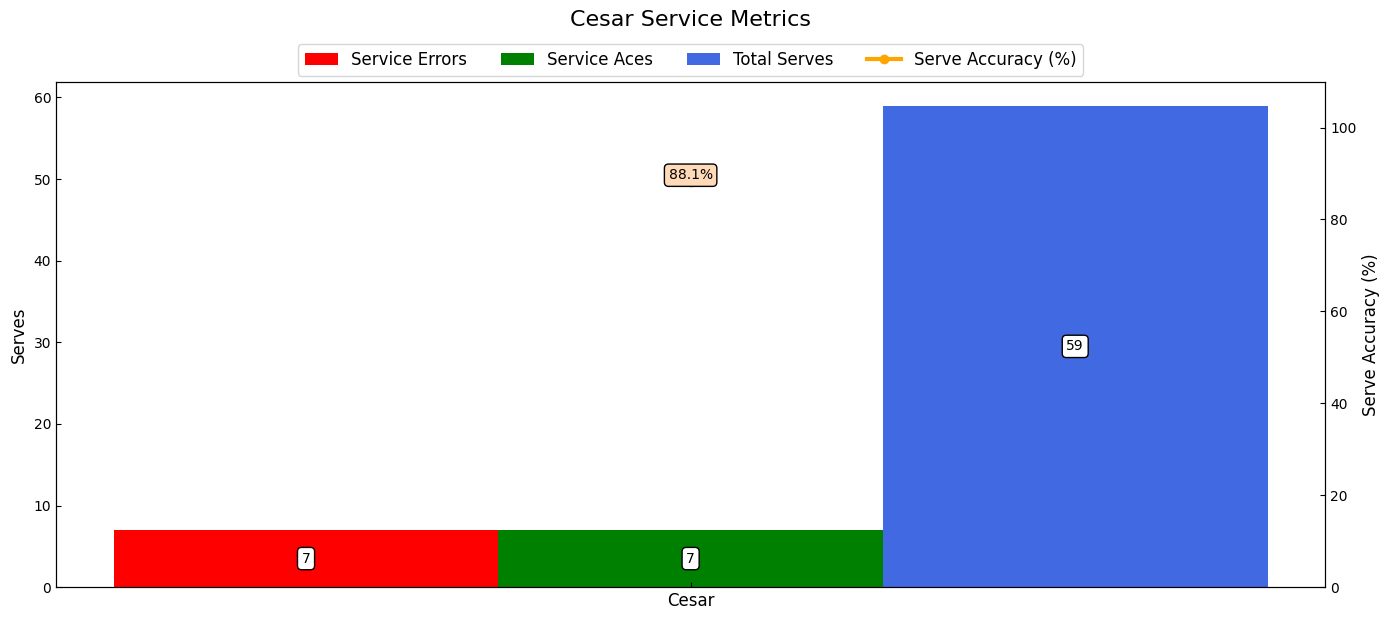

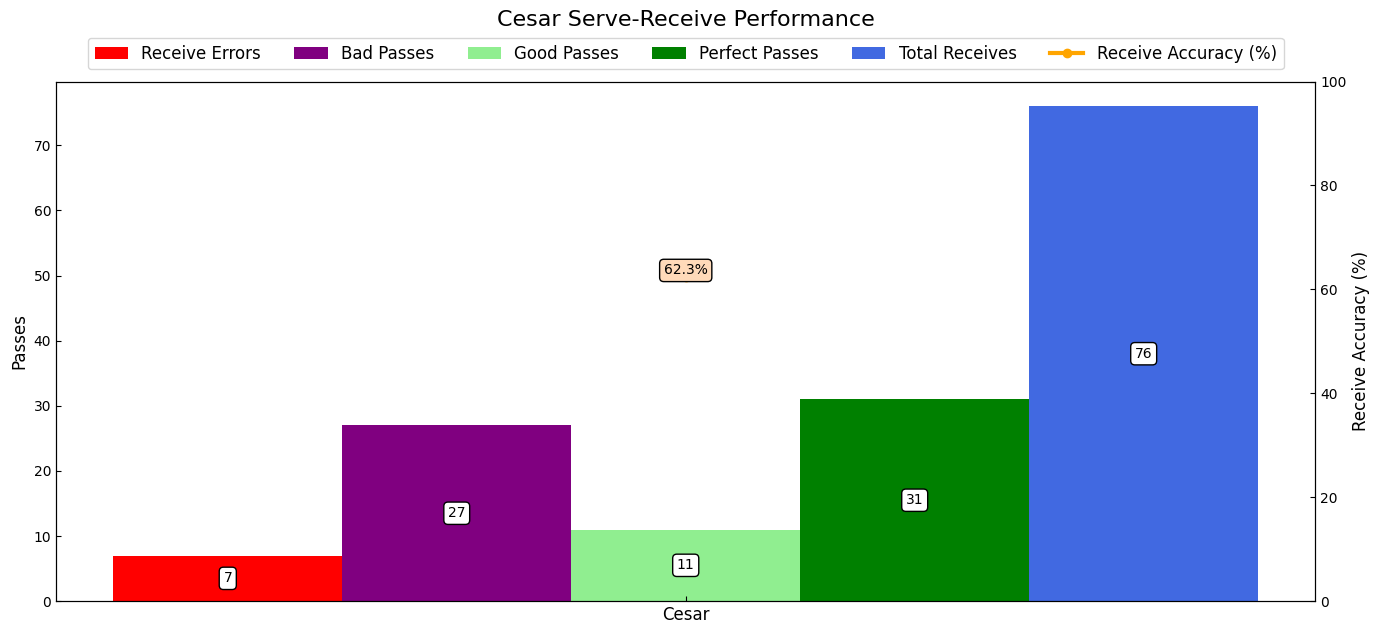

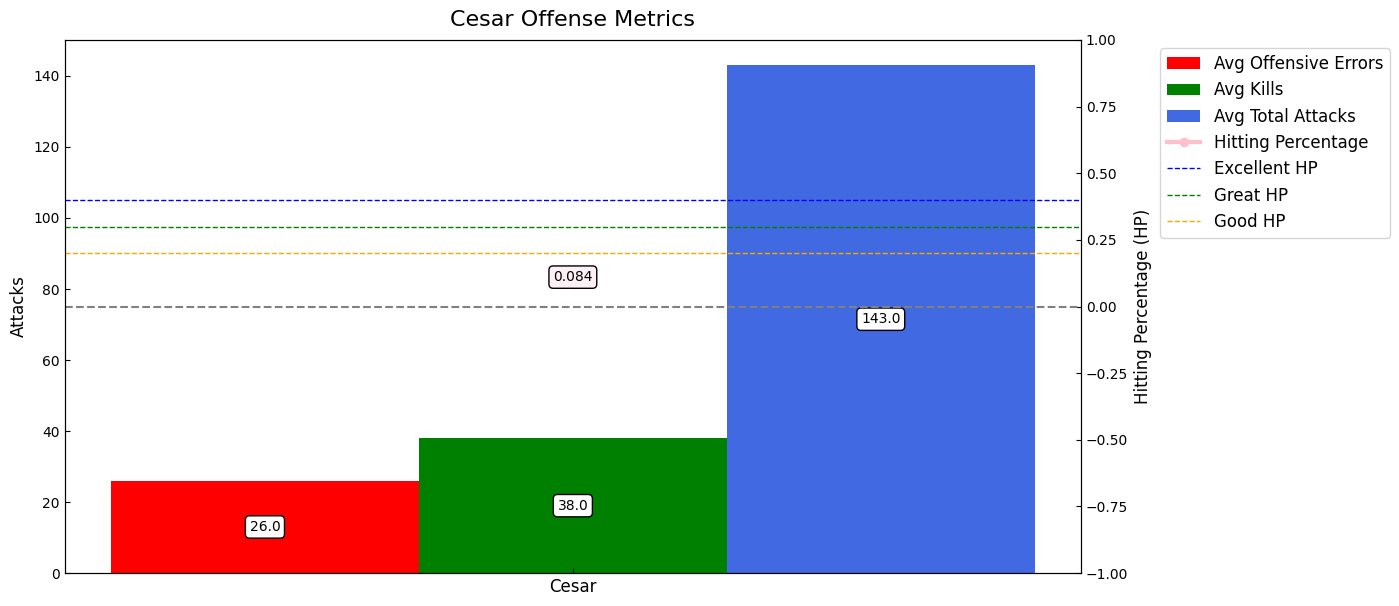

In [ ]:
# cumulative statistics
excluded_players = ['brandon']    # players who i don't care for (setters)
plot_service_metrics(df=df_overall, player_name=player_name)
plot_receive_performance(
    df=df_overall,
    exclude_players=excluded_players,
    player_name=player_name
    )
plot_offensive_performance(
    df_overall=df_overall,
    player_name=player_name,
    exclude_players=excluded_players,
    show_bad=False,
    show_good=False
    )

### ⏳ Performance Over Time by Set

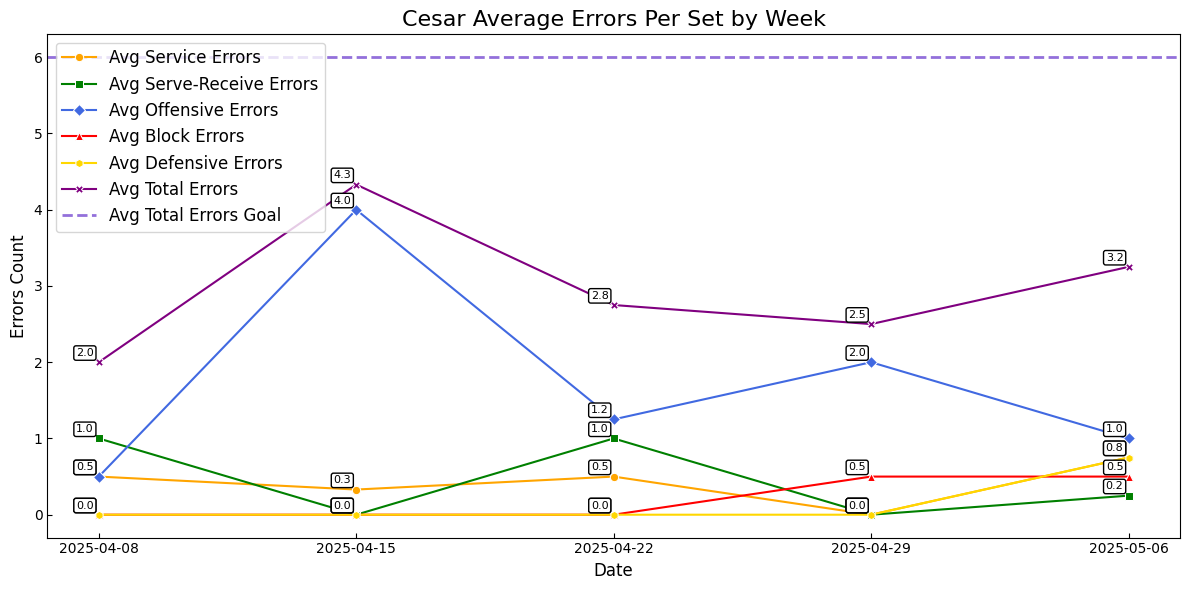

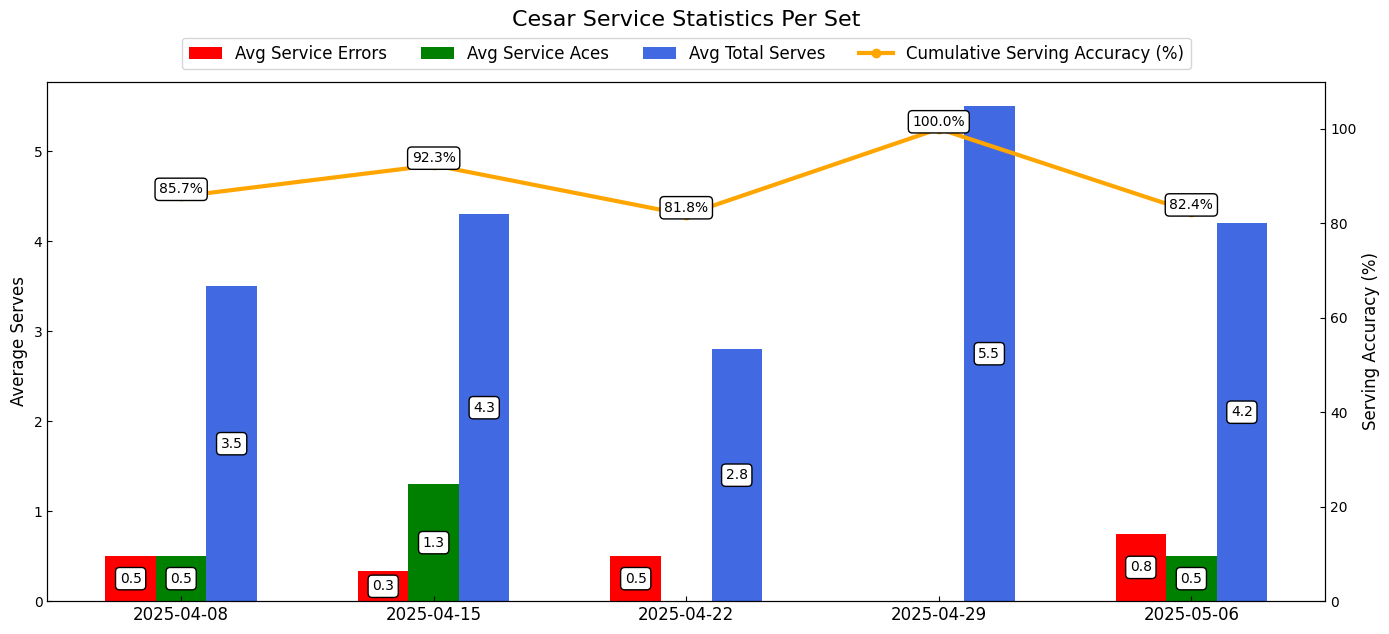

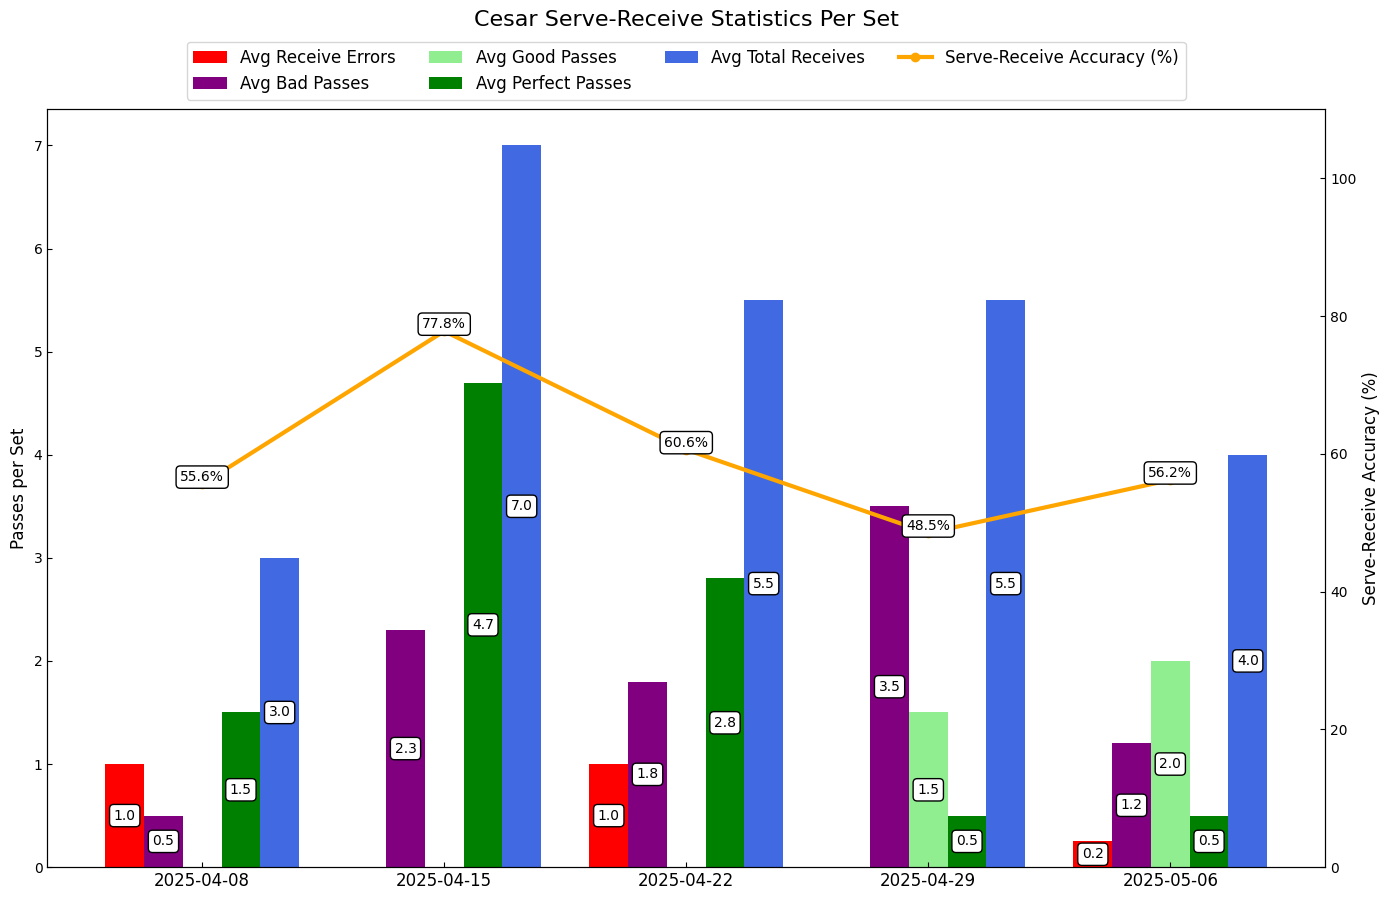

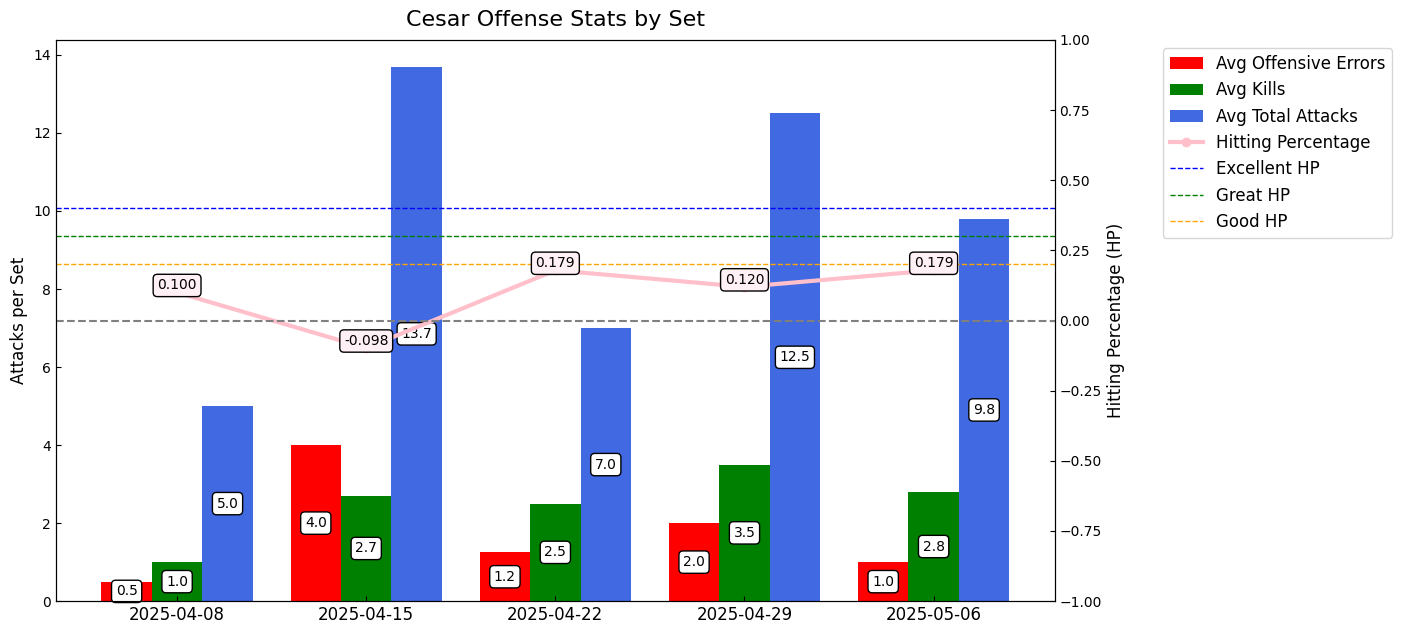

In [ ]:
# plot the time-series statistics (by set)
plot_avg_errors(team_overall, player_name)
plot_service_temporal(team_overall, player_name)
plot_receive_temporal(team_overall, player_name)
plot_offensive_temporal(
    team_overall,
    player_name,
    show_bad=False,
    show_good=False
    )

### 👓 General Overview

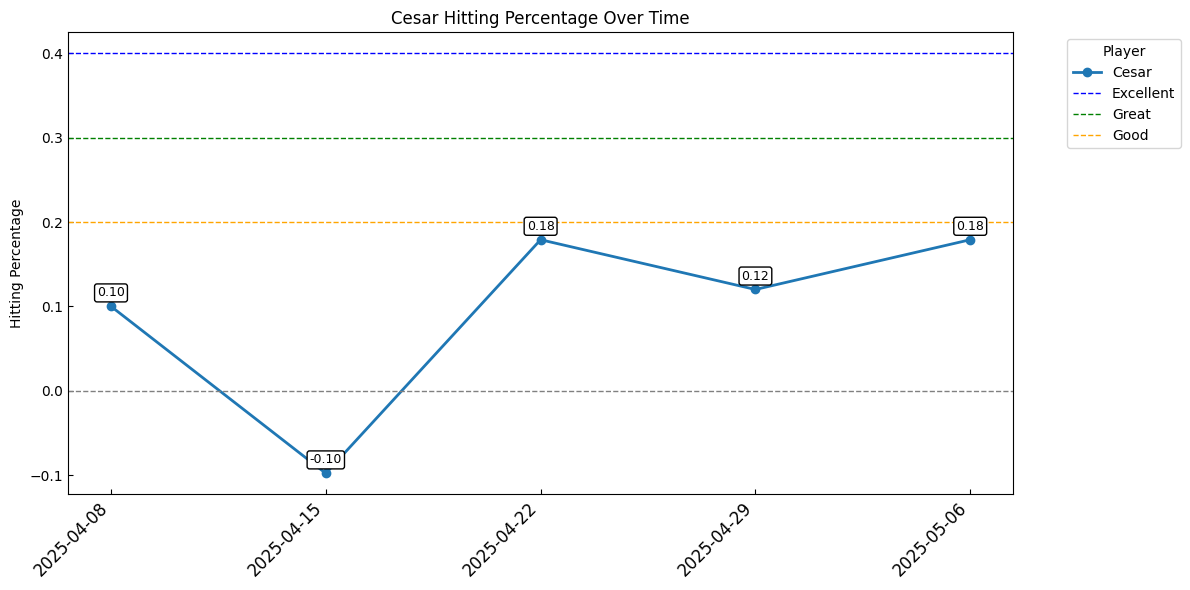

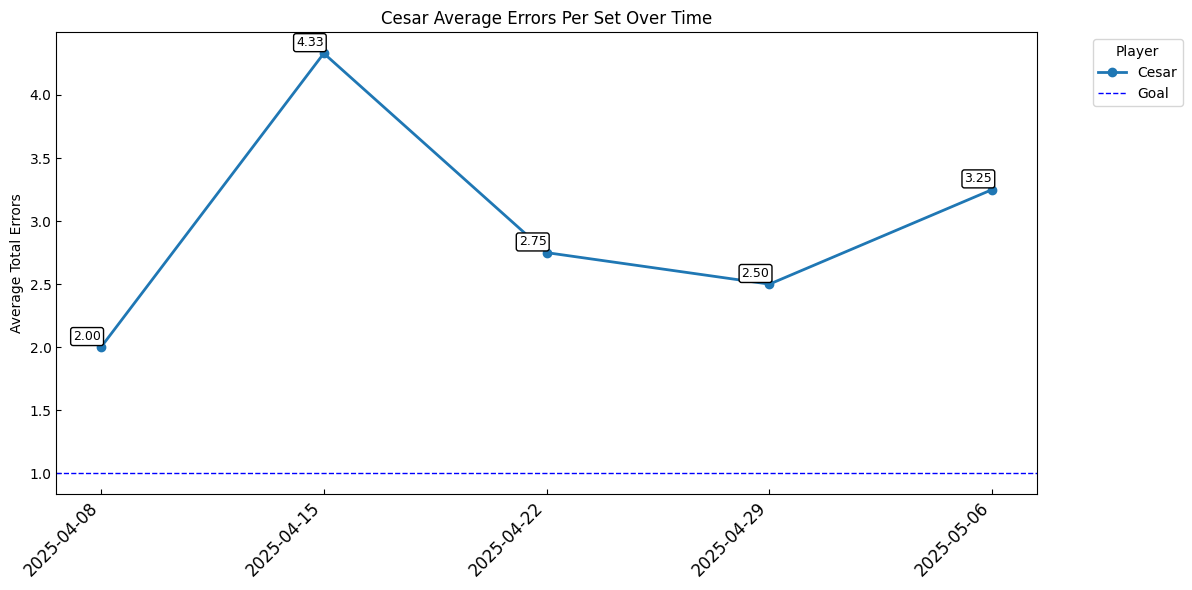

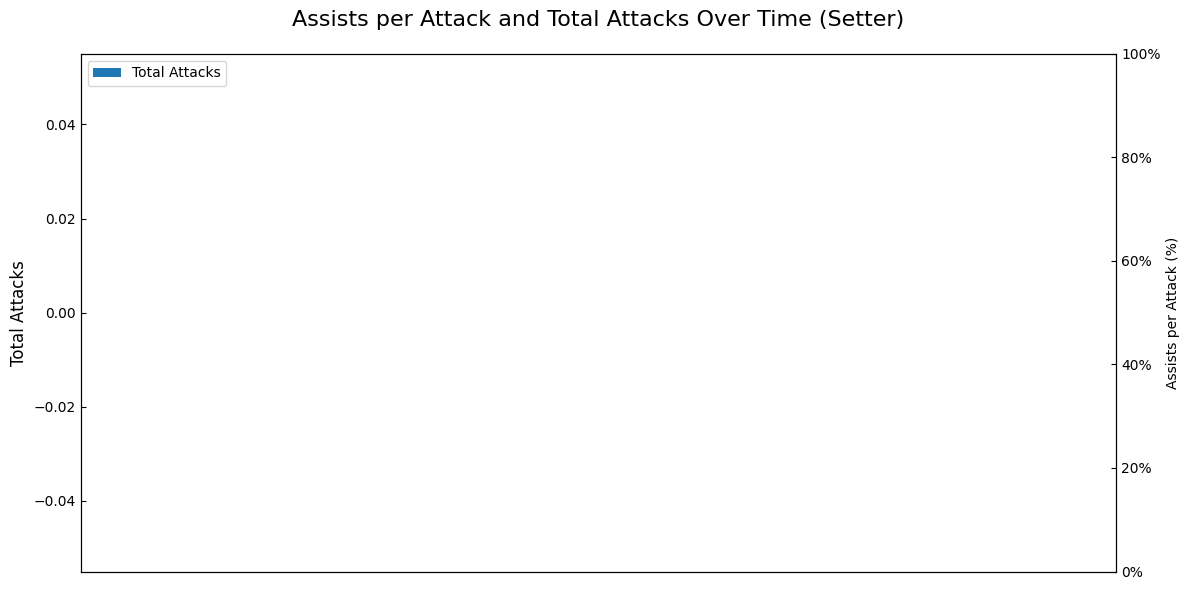

In [ ]:
# overview statistics
excluded_players = ['brandon']
plot_attack_accuracy(
    df_player_date_no_pos,
    player_name=player_name,
    exclude_players=excluded_players
    )
plot_player_errors(df_player_date_no_pos, player_name=player_name)

# setter assists
plot_assists_per_attack(
    df_player_date,
    team_overall,
    position='setter',
    # player_name='brandon'
    )